# Stock Price Prediction using LSTM
#
## This notebook demonstrates how to predict stock prices using a Long Short-Term Memory (LSTM) neural network.

## This week's (Week 5) tasks:
1. Implement a function that solve the multistep prediction problem to allow the prediction to be made for a sequence of closing prices of k days into the future.
2. Implement a function that solve the simple multivariate prediction problem to that takes into account the other features for the same company (including opening price, highest price, lowest price, closing price, adjusted closing price, trading volume) as the input for predicting the closing price of the company for a specified day in the future.
3. Combine the above two functions to solve the multivariate, multistep prediction problem.
4. Upload your Task 5 Report (as a PDF file) to the project Wiki before the deadline and email your project leader to notify that it is ready for viewing and feedback

### Create a Virtual Environment using `Conda` (If you have your own `Virutal Environment` your then ignore this !)

In [ ]:
# To activate the conda environment, copy the below content to `conda-config.sh` and run the following command in the terminal:
# sh conda-config.sh

'''conda-config.sh

conda create -n cos30019_env_w3_v0.2 python=3.10.9
conda activate cos30019_env_w3_v0.2
#Check current environment
conda info --envs
#Check current python version
python --version

'''

'conda-config.sh\n\nconda create -n cos30019_env_w3_v0.2 python=3.10.9\nconda activate cos30019_env_w3_v0.2\n#Check current environment\nconda info --envs\n#Check current python version\npython --version\n\n'

### Install essential libraries.

In [3]:
# !pip install -r requirements.txt
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install tensorflow
# !pip install scikit-learn
# !pip install pandas-datareader
# !pip install yfinance
# # !pip install -q TA-lib
# # Use this to install TA-lib on google colab
# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# !pip install joblib
# !pip install mplfinance

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4011    0  4011    0     0  13550      0 --:--:-- --:--:-- --:--:-- 13550
100  517k  100  517k    0     0   480k      0  0:00:01  0:00:01 --:--:--  480k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4031    0  4031    0     0  16479      0 --:--:-- --:--:-- --:--:-- 16520
100  392k  100  392k    0     0   328k      0  0:00:01  0:00:01 --:--:--  745k
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


### Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import talib as ta
import mplfinance as mpf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, InputLayer, Input, Activation, Bidirectional, GRU, SimpleRNN # type: ignore
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import pickle
from typing_extensions import Annotated, Doc, TypeVar, Literal, Tuple, Literal, Required, TypedDict, Optional, List, NotRequired
from datetime import timedelta, datetime
import os

### Declare essential variables
- Define the start date, the end date and the ticker (stock) that we wanted to download from `yfinance`.
- Define the split ratio for splitting the train and test data, and the number of days for looking back.
- Define the directory for storing the raw and prepared datasets.
- Define the files that are used for storing essential information, such as raw data imported from yfinance and the processed data.

In [3]:
# import os
# import sys
# from google.colab import drive
# DRIVE_DISK = '/content/drive'
# drive.flush_and_unmount();
# drive.mount(DRIVE_DISK)

# # Start, end and ticker for the datasets
# start="2015-01-01"
# end="2023-08-25"
# ticker="TSLA"

# ENTRY_POINT = f"{DRIVE_DISK}/MyDrive/COS30018/Week7/datasets/"
# os.chdir(ENTRY_POINT)


# # Split ratio, 0.8 equals to 80% data for training and 20% for testing
# split_ratio = 0.8

# # Number of days to look back for the prediction, could be changed to any value
# num_look_back_days = 30

# Start, end and ticker for the datasets
start="2015-01-01"
end="2023-08-25"
ticker="TSLA"

# Split ratio, 0.8 equals to 80% data for training and 20% for testing
split_ratio = 0.8

# Number of days to look back for the prediction, could be changed to any value
num_look_back_days = 30

# Define entry directory for the raw and prepared datasets
ENTRY_POINT = f"datasets/{ticker}/from_{start}_to_{end}"

# Define entry directory for the raw and prepared datasets
# ENTRY_POINT = f"datasets/{ticker}/from_{start}_to_{end}"
RAW_DATA_DIRECTORY = os.path.join(ENTRY_POINT, "data")
PREPARED_DATA_DIRECTORY = os.path.join(ENTRY_POINT, "prepared-data")

# # Raw data to be saved as the same for
# RAW_CSV_FILE = os.path.join(RAW_DATA_DIRECTORY, f"raw_data_from_{start}_to_{end}_of_{ticker}_stock.csv")

# # Prepared data to be saved as the same for
# PREPARED_CSV = os.path.join(PREPARED_DATA_DIRECTORY, f"prepared_data_from_{start}_to_{end}_of_{ticker}_stock.csv")
# PREPARED_TRAIN_ALL = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_data_{start}-{end}-{ticker}_stock.npz")
# PREPARED_TRAIN_DATASET = os.path.join(PREPARED_DATA_DIRECTORY, f"train_dataset_of_{ticker}_from_{start}_to_{end}.csv")
# PREPARED_TEST_DATASET = os.path.join(PREPARED_DATA_DIRECTORY, f"test_dataset_of_{ticker}_from_{start}_to_{end}.csv")
# PREPARED_SCALER_FEATURE = os.path.join(PREPARED_DATA_DIRECTORY, f"feature_scaler_of_{ticker}_from_{start}_to_{end}.pkl")
# PREPARED_SCALER_TARGET = os.path.join(PREPARED_DATA_DIRECTORY, f"targe_scaler_of_{ticker}_from_{start}_to_{end}.pkl")
# PREPARED_TRAIN_ARRAY = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_train_array_of_{ticker}_from_{start}_to_{end}.npz")
# PREPARED_TEST_ARRAY = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_test_array_of_{ticker}_from_{start}_to_{end}.npz")

### Ensure that directory must exists
- check_directory_exists() & create_directory(): The purpose of these two functions are two check if the given dir_path is exists or not using os.path.isdir(), if not then the check_directory_exists() will return a False and use create_directory() to create a folder based on the given dir_path, otherwise return True.
- check_file_exists(): This function will check if the file exists using os.path.exists() function, it will return True if exists otherwise return False.

In [4]:
def check_directory_exists(dir_path: Annotated[str, Doc("The path to the directory to be checked")]) -> bool:
    return True if os.path.isdir(dir_path) else False

def create_directory(dir_path: Annotated[str, Doc("The path to the directory to be created")]) -> None:
    os.makedirs(dir_path)

def check_file_exists(file_path: Annotated[str, Doc("The path to the file to be checked")]) -> bool:
    return True if os.path.exists(file_path) else False

### Utility function to load and save data objects
**The load_and_save_object() function does the following procedure:**
- If the mode is set to save, the function will start opening up the file defined in fn parameter. Once the file is successfully opened, it will write all of the given objects defined in obj by using pickle.dump() to ensure that the object will be type-safe when loading the object from the file.
- If the mode is set to load, the function will start reading from the file defined in fn and load the object using pickle.load() function

In [5]:
T = TypeVar("T", bound=Literal["load", "save"])
U = TypeVar("U", any, object)
def save_or_load_object(obj: Annotated[U | None, Doc("The object to be saved or loaded")],
                         fn: Annotated[str, Doc("The filename to the directory to be checked")],
                         mode: Annotated[T, Doc("The mode to be used")]) -> U | None:
    # Save the object to the file if the mode is save
    if mode == "save":
        with open(fn, "wb") as i:
            pickle.dump(obj, i)
    # Load the object from the file if the mode is load
    elif mode == "load":
        # Check if the object is None, if so then load the object from the file
        if obj is None:
            with open(fn, "rb") as i:
                return pickle.load(i)
        else:
            raise ValueError("obj must be None when mode is load")
    # Raise an error if the mode is invalid
    else:
        raise ValueError("Invalid mode")

### Load data function. Check if exists data, if not then load and save from the `yfinance`
- **The major purpose of this function is to check if the unprocessed CSV file that contains the stock data from the start date and end date is existed in the file or not, if it is not existed then it will download the data from yfinance and save it to the directory that contains unprocessed CSV data. Otherwise, it will load the unprocessed CSV File. The following procedures are:**
    - The code will check if the directory that contains unprocessed CSV file exists, if not then it will start to create the directory and download the CSV from the yfinance. Once it’s downloaded then it will convert the data to CSV Format and save it to the created directory.
    - However, in the case where the directory exists then it will read the file in that directory.


In [6]:
def load_data(start: Annotated[str, Doc("The start date of the stock to be loaded")],
              end: Annotated[str, Doc("The end date of the stock to be loaded")],
              ticker: Annotated[str, Doc("The ticker symbol of the stock to be loaded")] = "CBA.AX"):
    try:
      RAW_CSV_FILE = os.path.join(RAW_DATA_DIRECTORY, f"raw_data_from_{start}_to_{end}_of_{ticker}_stock.csv")
      # Check if the raw data directory exists, if not then create it
      if not check_directory_exists(RAW_DATA_DIRECTORY):
        create_directory(RAW_DATA_DIRECTORY)
        data = yf.download(ticker, start=start, end=end)
        data.to_csv(RAW_CSV_FILE)
      else:
          # Load the data from the local machine
          if not check_file_exists(RAW_CSV_FILE):
            data = yf.download(ticker, start=start, end=end)
            data.to_csv(RAW_CSV_FILE)
          else:
            data = pd.read_csv(RAW_CSV_FILE)
      return data
    except FileNotFoundError as e:
      raise FileNotFoundError


### Split data by ratio
**This function will do the following procedures:**
- If is_split_by_date is set to True: This function will perform calculation based on the split ratio (0.8 will equal 80% of train data and 20% of test data). Once the calculation is finished, the function will allocate the train and test data to the train_data and test_data variables.
- If is_split_by_date is set to False: This function will use the built-in function provided by scikit-learn, which is train_test_split() to split the data randomly based on the given ratio value. The random_state is fixed at 42 to make sure that the splitted data is reproducible.
- Once the data has been successfully splitted, it will then print out the shape (x,y) of both train and test data and return it to the user for further usages.

In [7]:
def split_data_by_ratio(data: Annotated[pd.DataFrame, Doc("The data to be split")],
                        ratio: Annotated[float, Doc("The ratio to be used in percentage: 0.8 for 80% train and 20% test")],
                        is_split_by_date: Annotated[bool, Doc("Choose to split by date or random")] = True) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Check if the data is split by date
    if is_split_by_date:
        # Calculate the train data size of the train data
        train_size = int(len(data) * ratio)
        # Split the data into train and test data
        train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
    else:
        # Split the data into train and test data randomly
        train_data, test_data = train_test_split(data,train_size=1 - (1 - ratio), test_size= 1 - ratio, random_state=42)

    # Print the shape of the train and test data
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    return train_data, test_data

### Scaling data using `MinMaxScaler()`
- **This function will check if the is_scale equals to True or not, if it is not then the function will simply return back the data without any scaling data. Otherwise, it will do the following procedures:**
    - Scaling data: This function will use the MinMaxScaler class provided by scikit-learn to scale the data to the range of (0, 1) by setting the feature_range to a tuple of (0, 1).
    - Reshaping data: After the data is scaled, the data will be converted into a two-dimensional array using reshape(-1, 1) function. This procedure is essential as the fit_transform() function only accepts a 2D array.
    - Fitting and returning the scaled array: Once the array is transformed to 2D array, it will be fitted using the fit_transform() function provided by class MinMaxScaler. Once the transform is finished we will return the scaled data with the instance of MinMaxScaler for further usage.

In [8]:
def scaling_data(data: Annotated[pd.DataFrame, Doc("The data to be scaled")], is_scale: Annotated[bool, Doc("Choose to scale or not, default set to True")] = True) -> Tuple[pd.DataFrame, MinMaxScaler | None]:
    if is_scale:
        # Using MinMaxScaler to scale the data to the range of (0, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        if len(data.shape) == 1:
            # If the data array is 1D, convert to 2D array
            data = data.values.reshape(-1, 1)
        # Fit the 2D-transformed data into the scaler
        scaled_data = scaler.fit_transform(data)
        return scaled_data, scaler
    else:
        return data, None

### Validate data
**This function will check if the directory that contains processed data exists, if not then it will create a directory used for storing processed data.
Once the directory is created, it will check the existence of the processed CSV file. If the CSV file exists, it will read the CSV file using pd.read_csv() and return it. Otherwise, it will start the following procedure**:
- Read the unprocessed CSV file: It will read the unprocessed CSV file stored in the unprocessed folder.
- Convert and set index: After the unprocessed CSV file is successfully read, it will convert the value of Date column into the DateTime type and set the value inside the Date column as index. This will make it easier to operate time-based searching, simplify the plotting procedure and enhance the data organization.
- Adding essential indicators to the data: This function will also add several required technical analysis indicators to the data, such as Relative Strength Index (RSI) and several different date ranges (20 days, 100 days and 150 days) of Exponential Moving Averages (EMA) using the built-in functions provided by TA-lib.
- Calculate target price: After adding indicators to the data, it will start calculating the target price by subtracting the value of Adjustment Close Price and the Open Price. Once subtracted, it will shift the value back by one to assume that is the targeted price.
- Indicate if the value is increased or not: It will calculate the TargetClass based on the target price value and indicate if the price is increased or not, if the price is increased then the TargetClass value will be 1, otherwise it will be 0.
- Drop all undefined values: By using dropna() function, it will look up all of the undefined (NaN) values and drop it.
- Save processed data: Once the datasets are processed, it will save those datasets into a CSV File by using to_csv() function and return the processed datasets to the user.

In [9]:
def validate_data(start: Annotated[str, "Start date"],
                  end: Annotated[str, "End date"],
                  tick: Annotated[int, "Tick"]) -> pd.DataFrame:

    RAW_CSV_FILE = os.path.join(RAW_DATA_DIRECTORY, f"raw_data_from_{start}_to_{end}_of_{ticker}_stock.csv")
    PREPARED_CSV = os.path.join(PREPARED_DATA_DIRECTORY, f"prepared_data_from_{start}_to_{end}_of_{ticker}_stock.csv")

    # Check if the prepared data directory exists, if not then create it
    if not check_directory_exists(PREPARED_DATA_DIRECTORY):
        create_directory(PREPARED_DATA_DIRECTORY)

    if check_file_exists(PREPARED_CSV):
        print('Loading Prepared Data...')
        df = pd.read_csv(PREPARED_CSV)
    else:
        print('Processing Raw Data...')
        # Read the raw data
        df = pd.read_csv(RAW_CSV_FILE)
        # Convert the date column to datetime
        if not isinstance(df.index, pd.DatetimeIndex):
            df['Date'] = pd.to_datetime(df['Date'])
            # Set the date column as the index
            df.set_index('Date', inplace=True)
        print("Type of index after converted: ", type(df.index))
        # Adding RSI, EMA20(EMA for 20 days), EMA100(EMA for 100 days), EMA200(EMA for 200 days)
        df['Close_RSI'] = ta.RSI(df['Close'], timeperiod=14)
        df['Close_EMA20'] = ta.EMA(df['Close'], timeperiod=20)
        df['Close_EMA100'] = ta.EMA(df['Close'], timeperiod=100)
        df['Close_EMA200'] = ta.EMA(df['Close'], timeperiod=200)

        # Calculate the target value by subtracting the open price
        # and the adjusted close price and shifting it by 1 day
        df['Target'] = df['Adj Close'] - df['Open']
        df['Target'] = df['Target'].shift(-1)

        # Convert the target class to binary class if the target is greater than 0
        df['TargetClass'] = np.where(df['Target'] > 0, 1, 0)
        # Shift the adjusted close price by 1 day
        df['TargetNextClose'] = df['Adj Close'].shift(-1)

        # Drop the NaN values
        df.dropna(inplace=True)

        # Convert to csv and save to the folder
        df.to_csv(PREPARED_CSV, index=False)
    return df


### Create datasets
**The given procedure, which is the heart to execute successfully the program, does the following steps:**
- Load and validate data: The procedure initially calls to the defined load_data() function, which will either load the existing raw data or download the data if it does not exist. Once the data is loaded successfully, it will call the validate_data() function to process and validate the data to be in the right format, which adds in extra technical analysis indicators and target values.
- Check the existence of the prepared datasets: After the data is validated, it will check if the train and test datasets exist. If the datasets are existed, it will do the following steps:
    - Load from the processed CSV file the existing datasets, including train and test datasets.
    - Print out the shapes of both train and test datasets for validation.
    - Load the saved scaler values of both feature and target.
    - Retrieve the value from the x and y array of both train and test arrays.
- In case where the datasets are not existed, the following logic will be executed:
    - The validated data will be split into train and test data using the defined split_data_by_ratio() function. With the split rate defined at 0.8 (80% of train data, 20% of test data).
    - Scale the training data for the features using the defined scaling_data() function and based on the defined feature_cols columns.
    - Make training arrays by creating a sequence for each sample based on the defined variable num_look_back_days.
    - Scale the testing data for the features and target using the defined scaling_data() function and based on the defined feature_cols and target_cols columns.
    - Make test arrays by creating a sequence of each sample based on the defined variable num_look_back_days.
    - Save the train and test data to a CSV file by using the to_csv()function from pandas and save the feature and target scalers using the defined save_or_load_object() function.
    - Save the created train and test arrays to a .npz file using savez()function from numpy.


In [10]:

PREPARED_TRAIN_ALL = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_data_{start}-{end}-{ticker}_stock.npz")
PREPARED_TRAIN_DATASET = os.path.join(PREPARED_DATA_DIRECTORY, f"train_dataset_of_{ticker}_from_{start}_to_{end}.csv")
PREPARED_TEST_DATASET = os.path.join(PREPARED_DATA_DIRECTORY, f"test_dataset_of_{ticker}_from_{start}_to_{end}.csv")
PREPARED_SCALER_FEATURE = os.path.join(PREPARED_DATA_DIRECTORY, f"feature_scaler_of_{ticker}_from_{start}_to_{end}.pkl")
PREPARED_SCALER_TARGET = os.path.join(PREPARED_DATA_DIRECTORY, f"targe_scaler_of_{ticker}_from_{start}_to_{end}.pkl")
PREPARED_TRAIN_ARRAY = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_train_array_of_{ticker}_from_{start}_to_{end}.npz")
PREPARED_TEST_ARRAY = os.path.join(PREPARED_DATA_DIRECTORY, f"xytrain_test_array_of_{ticker}_from_{start}_to_{end}.npz")

data = load_data(start, end, ticker)
df = validate_data(start, end, ticker)

if check_file_exists(PREPARED_TRAIN_DATASET) and check_file_exists(PREPARED_TEST_DATASET):
    print('Loading Existed Train and Test Data...')
    train_data = pd.read_csv(PREPARED_TRAIN_DATASET)
    test_data = pd.read_csv(PREPARED_TEST_DATASET)

    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    train_feature_scale = save_or_load_object(None, PREPARED_SCALER_FEATURE, "load")
    train_target_scale = save_or_load_object(None, PREPARED_SCALER_TARGET, "load")
    train_arrays = np.load(PREPARED_TRAIN_ARRAY)
    x_train = train_arrays['x_train']
    y_train = train_arrays['y_train']

    test_arrays = np.load(PREPARED_TEST_ARRAY)
    x_test = test_arrays['x_test']
    y_test = test_arrays['y_test']
else:
    print('Processing Train and Test Data...')
    train_data, test_data = split_data_by_ratio(df, split_ratio)

    feature_cols = ['Open', 'High', 'Low', 'Close_RSI', 'Close_EMA20', 'Close_EMA100', 'Close_EMA200']
    target_cols = 'TargetNextClose'

    scaled_train_data, train_feature_scale = scaling_data(train_data[feature_cols])
    converted_2d_train_data = train_data[target_cols].values.reshape(-1, 1)
    scaled_train_target, train_target_scale = scaling_data(converted_2d_train_data)

    x_train, y_train = [], []
    for i in range(num_look_back_days, len(scaled_train_data)):
        x_train.append(scaled_train_data[i-num_look_back_days:i])
        y_train.append(scaled_train_target[i])

    x_train, y_train = np.array(x_train), np.array(y_train)

    scaled_test_data = train_feature_scale.transform(test_data[feature_cols])
    converted_2d_test_data = test_data[target_cols].values.reshape(-1, 1)
    scaled_test_target = train_target_scale.transform(converted_2d_test_data)

    x_test, y_test = [], []
    for i in range(num_look_back_days, len(scaled_test_data)):
        x_test.append(scaled_test_data[i-num_look_back_days:i])
        y_test.append(scaled_test_target[i])

    x_test, y_test = np.array(x_test), np.array(y_test)

    train_data.to_csv(PREPARED_TRAIN_DATASET, index=False)
    test_data.to_csv(PREPARED_TEST_DATASET, index=False)

    save_or_load_object(train_feature_scale, PREPARED_SCALER_FEATURE, "save")
    save_or_load_object(train_target_scale, PREPARED_SCALER_TARGET, "save")

    np.savez(PREPARED_TRAIN_ARRAY, x_train=x_train, y_train=y_train)
    np.savez(PREPARED_TEST_ARRAY, x_test=x_test, y_test=y_test)

[*********************100%%**********************]  1 of 1 completed

Processing Raw Data...
Type of index after converted:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Processing Train and Test Data...
Train data shape: (1580, 13)
Test data shape: (396, 13)


### Type and Shape of the processed data

In [11]:
print("Data Preparation Completed!")
print("Data: ", type(data))
print("Data: ", type(df))
print("Index: ", type(df.index))
print("Train Data: ", train_data.shape)
print("Test Data: ", test_data.shape)
print("Train Feature Scaler: ", type(train_feature_scale))
print("Train Target Scaler: ", type(train_target_scale))
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

Data Preparation Completed!
Data:  <class 'pandas.core.frame.DataFrame'>
Data:  <class 'pandas.core.frame.DataFrame'>
Index:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Train Data:  (1580, 13)
Test Data:  (396, 13)
Train Feature Scaler:  <class 'sklearn.preprocessing._data.MinMaxScaler'>
Train Target Scaler:  <class 'sklearn.preprocessing._data.MinMaxScaler'>
x_train:  (1550, 30, 7)
y_train:  (1550, 1)
x_test:  (366, 30, 7)
y_test:  (366, 1)


### Raw data informations

In [12]:
print(len(data))
data.head(3)
data.tail(3)

2176


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900
2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600
2023-08-24,238.660004,238.919998,228.179993,230.039993,230.039993,99777400


### Value counts for the transformed TargetClass

In [13]:
print(len(df))
df.tail(3)
print(type(df.index))

1976
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### Length of the train data and the train data informations

In [14]:
print(len(train_data))
train_data

1580


,Open,High,Low,Close,Adj Close,Volume,Close_RSI,Close_EMA20,Close_EMA100,Close_EMA200,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-10-16,14.869333,15.365333,14.858000,15.134000,15.134000,65017500,41.229110,15.641226,16.178118,15.453410,0.106667,1,15.206667
2015-10-19,15.100000,15.410000,14.996000,15.206667,15.206667,37618500,42.261541,15.599840,16.158881,15.450955,-0.979333,0,14.202000
2015-10-20,15.181333,15.240000,13.466667,14.202000,14.202000,223500000,33.499486,15.466712,16.120131,15.438527,-0.126667,0,14.006000
2015-10-21,14.132667,14.320667,13.920000,14.006000,14.006000,62272500,32.101185,15.327597,16.078267,15.424273,0.010667,1,14.114667
2015-10-22,14.104000,14.383333,13.960000,14.114667,14.114667,42378000,33.752239,15.212080,16.039384,15.411242,-0.394000,0,13.939333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,347.236664,351.556671,331.666656,331.883331,331.883331,75442500,44.177604,350.436713,320.841134,283.489855,-4.486664,0,332.089996
2022-01-20,336.576660,347.220001,331.333344,332.089996,332.089996,70488600,44.251926,348.689407,321.063884,283.973438,-17.480011,0,314.633331
2022-01-21,332.113342,334.850006,313.500000,314.633331,314.633331,103416000,39.471455,345.445971,320.936546,284.278512,8.413330,1,310.000000


### Length of the test data and the test data informations

In [15]:
print(len(test_data))
test_data

396


,Open,High,Low,Close,Adj Close,Volume,Close_RSI,Close_EMA20,Close_EMA100,Close_EMA200,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-26,317.476654,329.230011,302.000000,312.470001,312.470001,104867400,40.058582,336.154503,320.273490,285.025188,-34.753326,0,276.366669
2022-01-27,311.119995,311.796661,276.333344,276.366669,276.366669,147109500,31.509505,330.460424,319.404048,284.939034,4.929993,1,282.116669
2022-01-28,277.186676,285.833344,264.003326,282.116669,282.116669,134789100,33.928006,325.856256,318.665684,284.910951,21.336670,1,312.239990
2022-01-31,290.903320,312.663330,287.350006,312.239990,312.239990,104436000,44.904252,324.559469,318.538442,285.182881,-1.320007,0,310.416656
2022-02-01,311.736664,314.566681,301.666656,310.416656,310.416656,73138200,44.423197,323.212535,318.377615,285.433964,-7.506683,0,301.886658
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-17,226.059998,226.740005,218.830002,219.220001,219.220001,120718400,28.822402,247.343352,230.881828,222.207176,1.370010,1,215.490005
2023-08-18,214.119995,217.580002,212.360001,215.490005,215.490005,135813700,27.398660,244.309700,230.577040,222.140338,9.729996,1,231.279999
2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700,40.743054,243.068776,230.590960,222.231280,-7.059998,0,233.190002


### Expected and actual train / test radio

In [16]:
print("Actual Ratio: ", split_ratio)
print("Received train ratio: ", len(train_data) / len(df))
print("Received test ratio: ", len(test_data) / len(df))

Actual Ratio:  0.8
Received train ratio:  0.7995951417004049
Received test ratio:  0.20040485829959515


### The processed close price of the TSLA stock

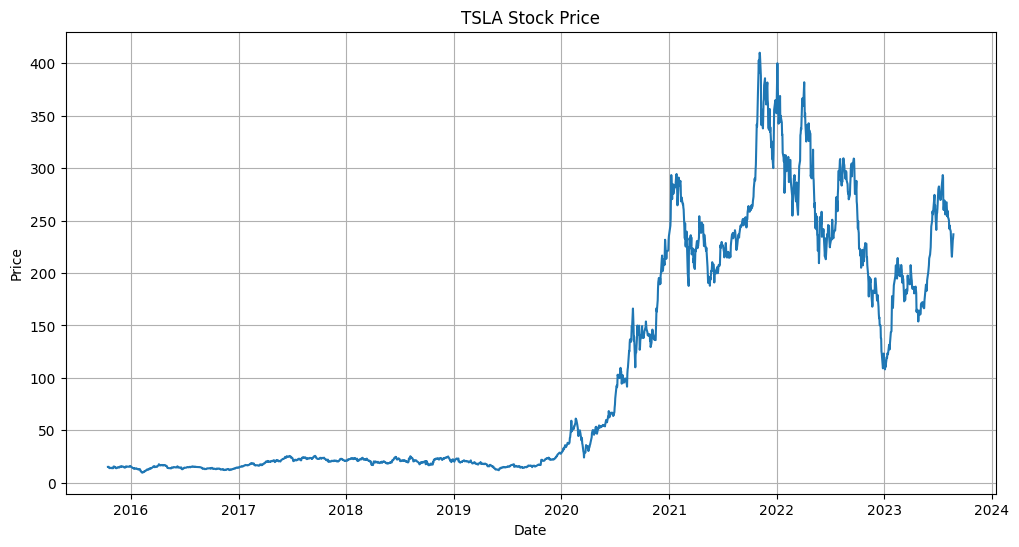

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### TSLA Closing Price with 20 / 100 / 200 days index of EMA

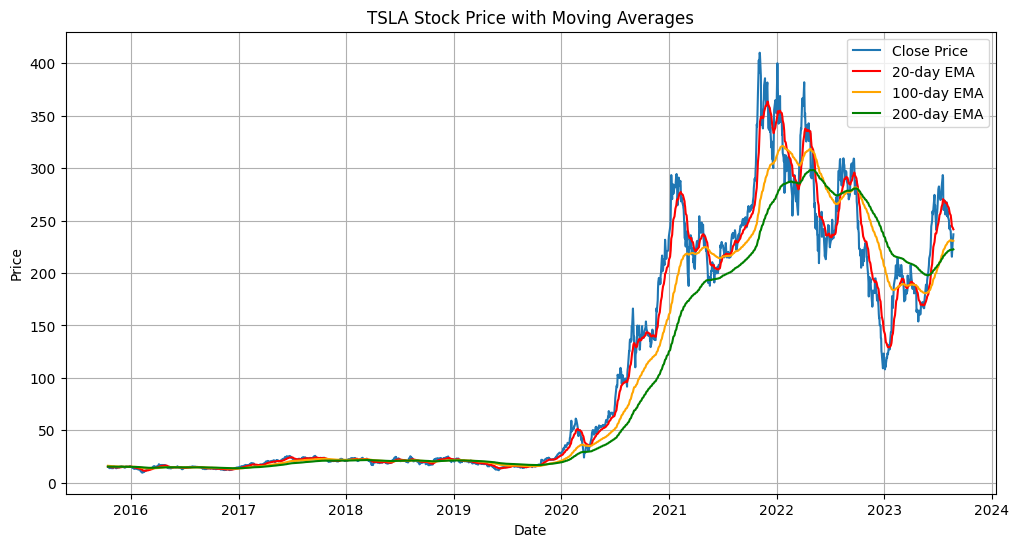

In [17]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['Close_EMA20'], label='20-day EMA', color="red")
plt.plot(df.index, df['Close_EMA100'], label='100-day EMA', color="orange")
plt.plot(df.index, df['Close_EMA200'], label='200-day EMA', color="green")
plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### RSI Index of the TSLA

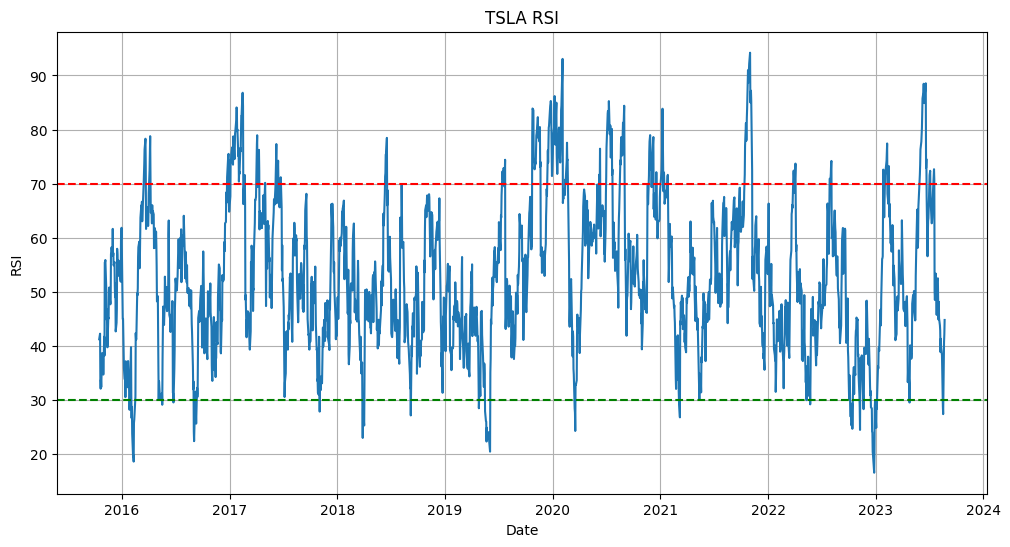

In [18]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close_RSI'])
plt.title(f'{ticker} RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.grid(True)
plt.show()

### Draw Candlestick Chart

**In short, the draw_candlestick_chart() will take in the dataframe and create a copy, once the copy is created then it will resample the data by the n trading days if n is not None. It then adds in essential technical analysis strategies as additional values to display on the chart and draw the candlestick chart using mplfinance. The following steps display the procedure of the draw_candlestick_chart():**

- Dataframe copy: When the dataframe is passed in as an argument, this function will start copying the dataframe using the copy() function provided by pandas. This step is critically essential, as it will prevent any unwanted changes that could be executed to the real dataframe.
- Data resample: The draw_candlestick_chart() will then check if the n parameter is not None, if the n parameter is not None then the function will start aggregating the data to find the maximum value of high price, minimum value of low price, first open price value, last close price value and the total of volumes within each resampling n period. Technical Analysis Strategies: Once the resampling procedure is finished, it will add three moving averages (MA) for the ‘Close’ price to the copied dataframe, which are 25 days, 100 days and 200 days moving average.
- Create Sub-Plot: The function also creates an array of make_addplot()instances, which will be used to display the moving averages (25 days, 100 days and 200 days) alongside the candlestick chart. However, before the chart is being appended to the array, it must be pre-processed by drop NaN values and reindexed for assuring safe data.
- Display the chart: Once the moving averages sub-plot procedure is finished, the function will utilize plot() function from mplfinance to display the candlestick chart. As shown in the codebase, this function will take in the dataframe that we have processed before, with some required parameters, which could be list as the type of the chart, the title of the chart, the style of the chart, the label name, the total volume of the data and the sub-plot that we have created before.

In [19]:
def draw_candlestick_chart(df: Annotated[pd.DataFrame, Doc("The data to be plotted")],
                           n: Annotated[int | None, Doc("Resampling period in trading days for aggregation, default is None")] = None,
                           ):
    cp_df = df.copy()
    if n is not None:
        cp_df = cp_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    cp_df['MA25'] = cp_df['Close'].rolling(window=25).mean()
    cp_df['MA100'] = cp_df['Close'].rolling(window=100).mean()
    cp_df['MA200'] = cp_df['Close'].rolling(window=200).mean()


    sub_chart: mpf.make_addplot  = []
    if cp_df.MA25.dropna().shape[0] > 0:
        fixed_MA25 = cp_df.MA25.dropna().reindex(cp_df.index, fill_value=None)
        sub_chart.append(mpf.make_addplot(fixed_MA25, color='blue'))
    if cp_df.MA100.dropna().shape[0] > 0:
        fixed_MA100 = cp_df.MA100.dropna().reindex(cp_df.index, fill_value=None)
        sub_chart.append(mpf.make_addplot(fixed_MA100, color='orange'))
    if cp_df.MA200.dropna().shape[0] > 0:
        fixed_MA200 = cp_df.MA200.dropna().reindex(cp_df.index, fill_value=None)
        sub_chart.append(mpf.make_addplot(fixed_MA200, color='green'))

    mpf.plot(cp_df, type='candle', style='charles', ylabel='Price', ylabel_lower='Volume', volume=True, addplot=sub_chart, title=f'{ticker} Stock Price with Moving Averages')





/Users/cobeo/miniconda3/envs/cos30019_env_w2_v0.2/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


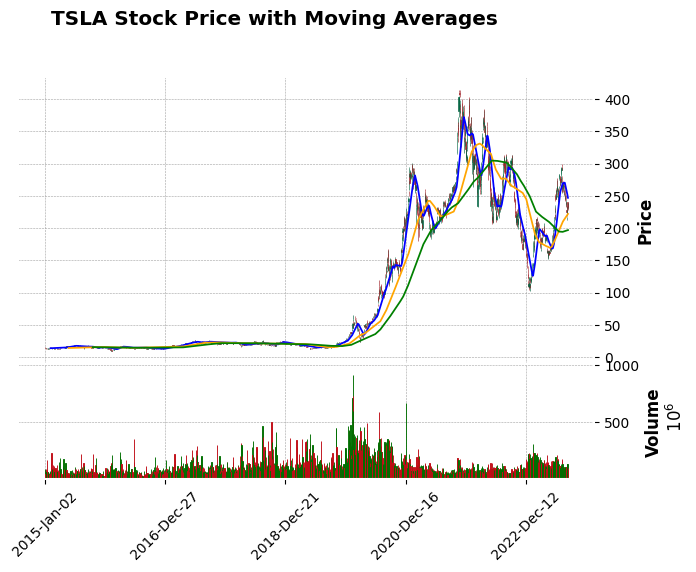

In [20]:
draw_candlestick_chart(data)

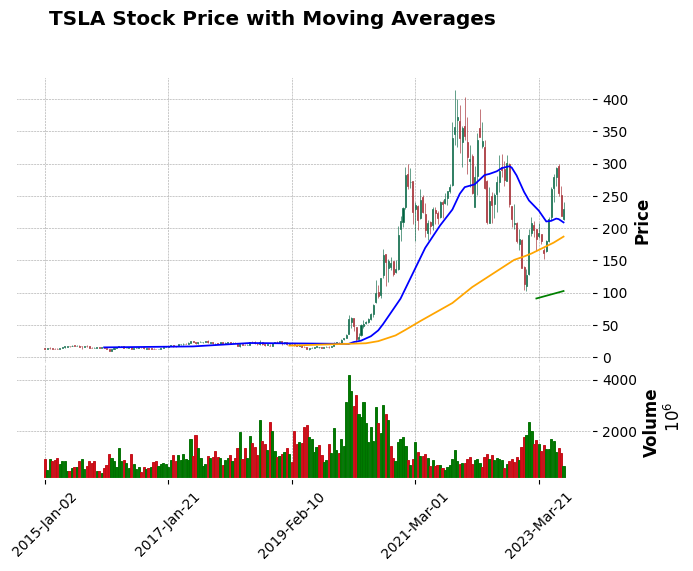

In [21]:
draw_candlestick_chart(data, n=15)

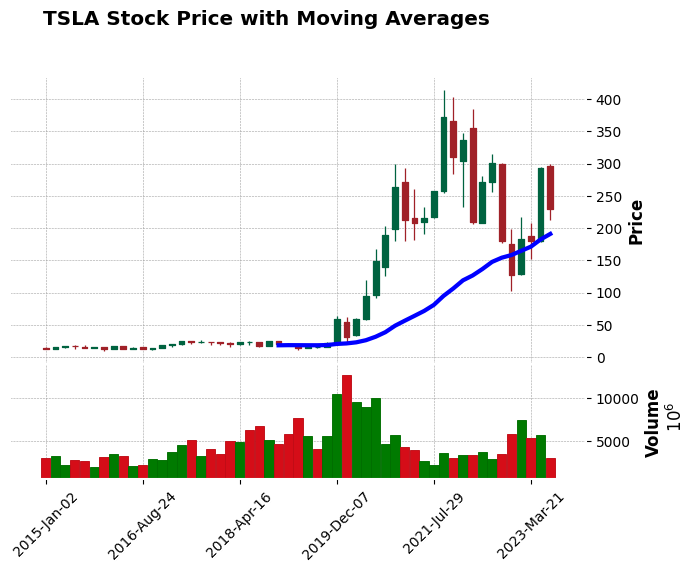

In [22]:
draw_candlestick_chart(data, n=60)

### Draw Box Chart

**The process of resampling data and the process of prepare data for the box plot is partially the same as the draw_candlestick_chart(), however, the key difference that separates the draw_box_chart() function is the way that it creates the sub-chart and the libraries that it uses for creating the chart. The below steps show the overall procedure of how the draw_box_chart() function work:**

- Dataframe copy: When the dataframe is passed in as an argument, this function will start copying the dataframe using the copy() function provided by pandas. This step is critically essential, as it will prevent any unwanted changes that could be executed to the real dataframe.
- Data resample: The draw_candlestick_chart() will then check if the n parameter is not None, if the n parameter is not None then the function will start aggregating the data to find the maximum value of high price, minimum value of low price, first open price value, last close price value and the total of volumes within each resampling n period.
- Data preparation: After the data resample is finished, the function will start preparing data for displaying to the plot. First, the two arrays of chart_data and labels are created. The chart_data contains the close, open, low and high price for each data point and the labels will contain the corresponding date for each data point.
- Chart display: After preparing the data, the function will start creating and configuring the chart. First, the function will use the subplots() function provided by matplotlib to create a figure and axes. It will then initialize and create the box chart using the boxplot() function (which is also provided by matplotlib). The prepared chart_data array will be used as the main data to draw the box plot with different parameters are set to customize the appearance of the chart, which could be listed as: vertical alignment, patch artist, label , title, label for x and y axis, x-tick interval, the label of the x-tick and the rotation degree of the chart. The k parameter that is defined in the function will be used for determining the interval for displaying the labels at which days. Finally, the show() function of matplotlib is called to display the charts.

In [23]:
def draw_box_chart(df: Annotated[pd.DataFrame, Doc("The data to be plotted")],
                    n: Annotated[int | None, Doc("Resampling period in trading days for aggregation, default is None")] = None,
                    k: Annotated[int, Doc("The interval of the box plot, default is 10")] = 10
                    ):
    cp_df = df.copy()

    if n is not None:
        cp_df = cp_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    chart_data: list = []
    labels: list = []

    for index, row in cp_df.iterrows():
        chart_data.append([row['Close'], row['Open'], row['Low'], row['High']])
        labels.append(index.strftime('%Y-%m-%d'))

    figure, axes = plt.subplots()
    axes.boxplot(chart_data, vert=True, patch_artist=True)
    axes.set_xticklabels(labels)
    axes.set_title(f'{ticker} Box Plot Chart')
    axes.set_xlabel('Date')
    axes.set_ylabel('Price')
    axes.set_xticks(range(1, len(labels) + 1, k))
    axes.set_xticklabels(labels[::k], rotation=90)

    plt.show()




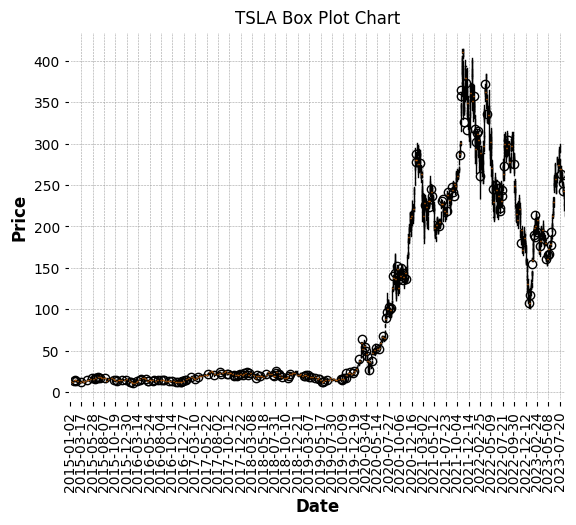

In [24]:
draw_box_chart(data, n=None , k=50)

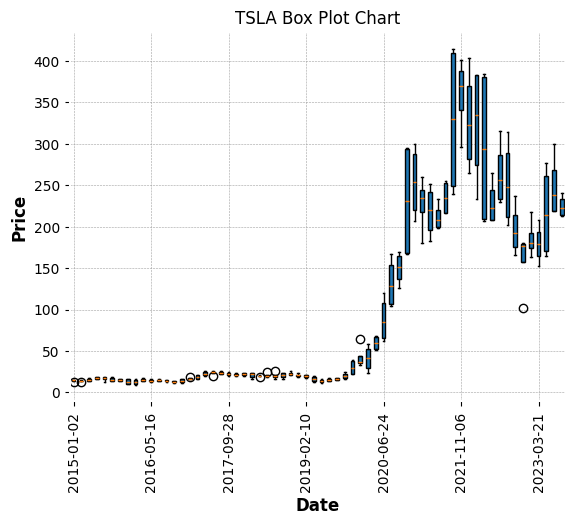

In [25]:
draw_box_chart(data, n=50, k=10)

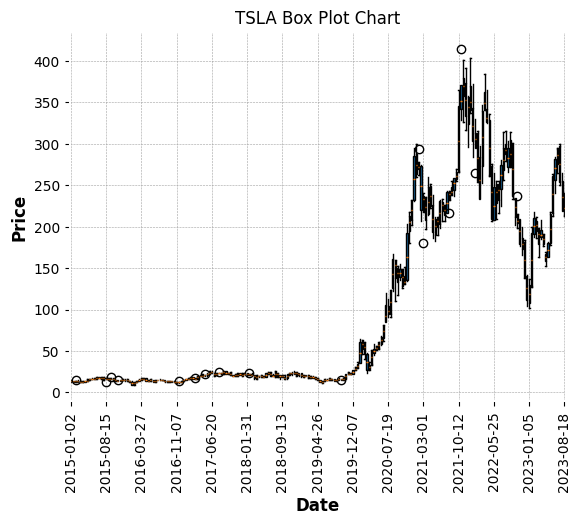

In [26]:
draw_box_chart(data, n=15, k=15)

In [27]:
class ModelConfig(TypedDict):
    type: Required[Literal["LSTM", "GRU", "RNN"]]
    isBidirectional: Required[bool]
    units: Required[int]
    return_sequences: Required[bool]
    dropout: Required[float]
    activation: NotRequired[Literal["tanh", "relu", "sigmoid", "softmax", "linear"]]

In [28]:
def make_dynamic_model(input_shape: tuple[int, int], config: List[ModelConfig], output_units: Optional[int] = 1):
    model = Sequential()

    first_layer = config[0]
    first_layer_type = first_layer['type']
    if first_layer['isBidirectional']:
        match first_layer_type:
            case "LSTM":
                model.add(Bidirectional(LSTM(units=first_layer['units'], return_sequences=first_layer['return_sequences']), input_shape=input_shape))
            case "GRU":
                model.add(Bidirectional(GRU(units=first_layer['units'], return_sequences=first_layer['return_sequences']), input_shape=input_shape))
            case "RNN":
                model.add(Bidirectional(SimpleRNN(units=first_layer['units'], return_sequences=first_layer['return_sequences']), input_shape=input_shape))
    else:
        match first_layer_type:
            case "LSTM":
                model.add(LSTM(units=first_layer['units'], return_sequences=first_layer['return_sequences'], input_shape=input_shape))
            case "GRU":
                model.add(GRU(units=first_layer['units'], return_sequences=first_layer['return_sequences'], input_shape=input_shape))
            case "RNN":
                model.add(SimpleRNN(units=first_layer['units'], return_sequences=first_layer['return_sequences'], input_shape=input_shape))

    if 'activation' in first_layer:
        model.add(Activation(first_layer['activation']))

    model.add(Dropout(first_layer['dropout']))

    for layer in config[1:]:
        multi_layer_type = layer['type']
        if layer['isBidirectional']:
            match multi_layer_type:
                case "LSTM":
                    model.add(Bidirectional(LSTM(units=layer['units'], return_sequences=layer['return_sequences']), input_shape=input_shape))
                case "GRU":
                    model.add(Bidirectional(GRU(units=layer['units'], return_sequences=layer['return_sequences']), input_shape=input_shape))
                case "RNN":
                    model.add(Bidirectional(SimpleRNN(units=layer['units'], return_sequences=layer['return_sequences']), input_shape=input_shape))
        else:
            match multi_layer_type:
                case "LSTM":
                    model.add(LSTM(units=layer['units'], return_sequences=layer['return_sequences'], input_shape=input_shape))
                case "GRU":
                    model.add(GRU(units=layer['units'], return_sequences=layer['return_sequences'], input_shape=input_shape))
                case "RNN":
                    model.add(SimpleRNN(units=layer['units'], return_sequences=layer['return_sequences'], input_shape=input_shape))

        if 'activation' in layer:
            print(layer['activation'])
            model.add(Activation(layer['activation']))

        model.add(Dropout(layer['dropout']))

    model.add(Dense(units=output_units))

    return model

In [29]:
def metric_plot(model_train_history: tf.keras.callbacks.History, metric_1: str, metric_2: str, plot_name: str):
    metric_1_values = model_train_history.history[metric_1]
    metric_2_values = model_train_history.history[metric_2]
    epochs = range(len(metric_1_values))
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metric_1_values, label=metric_1)
    plt.plot(epochs, metric_2_values, label=metric_2)
    plt.title(f'{plot_name} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

### Test case 1: LSTM, GRU, RNN with different activations

In [ ]:
# model_config: List[ModelConfig] = [
#     {
#         'type': 'LSTM',
#         'isBidirectional': False,
#         'units': 120,
#         'return_sequences': True,
#         'dropout': 0.2,
#         'activation': 'tanh'
#     },
#     {
#         'type': 'LSTM',
#         'isBidirectional': False,
#         'units': 100,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'GRU',
#         'isBidirectional': False,
#         'units': 80,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'RNN',
#         'isBidirectional': False,
#         'units': 60,
#         'return_sequences': True,
#         'dropout': 0.2,
#         'activation': 'relu'
#     },
#     {
#         'type': 'LSTM',
#         'isBidirectional': False,
#         'units': 40,
#         'return_sequences': False,
#         'dropout': 0.2,
#     },
# ]

### Test case 2: LSTM Model

In [ ]:
# model_config: List[ModelConfig] = [
#     {
#         'type': 'LSTM',
#         'isBidirectional': False,
#         'units': 50,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'LSTM',
#         'isBidirectional': False,
#         'units': 50,
#         'return_sequences': False,
#         'dropout': 0.2,
#     }
# ]

### Test case 3: GRU Model

In [30]:
model_config: List[ModelConfig] = [
    {
        'type': 'GRU',
        'isBidirectional': False,
        'units': 100,
        'return_sequences': True,
        'dropout': 0.2,
    },
    {
        'type': 'GRU',
        'isBidirectional': False,
        'units': 100,
        'return_sequences': False,
        'dropout': 0.2,
    }
]

### Test case 4: LSTM and GRU model mixed

In [ ]:
# model_config: List[ModelConfig] = [
#     {
#         'type': 'LSTM',
#         'isBidirectional': False,
#         'units': 100,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'GRU',
#         'isBidirectional': False,
#         'units': 100,
#         'return_sequences': False,
#         'dropout': 0.2,
#     }
# ]

### Test case 5: Bidirectional LSTM Model

In [ ]:
# model_config: List[ModelConfig] = [
#     {
#         'type': 'LSTM',
#         'isBidirectional': True,
#         'units': 128,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'LSTM',
#         'isBidirectional': True,
#         'units': 128,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'LSTM',
#         'isBidirectional': True,
#         'units': 128,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'LSTM',
#         'isBidirectional': True,
#         'units': 128,
#         'return_sequences': False,
#         'dropout': 0.2,
#     },

# ]

### Test case 6: Bidirectional GRU Model

In [ ]:
# model_config: List[ModelConfig] = [
#     {
#         'type': 'GRU',
#         'isBidirectional': True,
#         'units': 128,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'GRU',
#         'isBidirectional': True,
#         'units': 128,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'GRU',
#         'isBidirectional': True,
#         'units': 64,
#         'return_sequences': True,
#         'dropout': 0.2,
#     },
#     {
#         'type': 'GRU',
#         'isBidirectional': True,
#         'units': 64,
#         'return_sequences': False,
#         'dropout': 0.2,
#     }
# ]

In [31]:
n_steps = x_train.shape[1]
n_features = x_train.shape[2]
train_shape = (n_steps, n_features)
print(train_shape)

(30, 7)


In [ ]:
# del model

In [32]:
model = make_dynamic_model(train_shape, model_config)
model.summary()

/Users/cobeo/miniconda3/envs/cos30019_env_w2_v0.2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 100)        │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,401 (364.85 KB)

 Trainable params: 93,401 (364.85 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model_train_history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_cb], shuffle=True, validation_split=0.2)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 8.5889e-04 - loss: 0.0019 - val_accuracy: 0.0032 - val_loss: 0.0027
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.2602e-04 - loss: 4.4297e-04 - val_accuracy: 0.0032 - val_loss: 0.0029
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0011 - loss: 2.3420e-04 - val_accuracy: 0.0032 - val_loss: 0.0023
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 4.2596e-04 - loss: 3.3944e-04 - val_accuracy: 0.0032 - val_loss: 0.0030
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 5.7170e-04 - loss: 1.6955e-04 - val_accuracy: 0.0032 - val_loss: 0.0029
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.2602e-04 - loss: 1.8015e-04 - val_accuracy: 0.0032 - val_loss: 0.0021
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0033 - loss: 1.5387e-04 - val_accuracy: 0.0032 - val_loss: 0.0055
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accura

In [34]:
predict_price = model.predict(x_test)
predict_price = train_target_scale.inverse_transform(predict_price)
print(predict_price)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[280.40042 ]
 [279.64963 ]
 [275.7026  ]
 [266.90466 ]
 [265.28543 ]
 [271.76917 ]
 [279.27744 ]
 [288.77704 ]
 [298.4543  ]
 [309.2066  ]
 [320.13864 ]
 [325.64084 ]
 [327.6571  ]
 [340.79126 ]
 [349.55817 ]
 [352.5568  ]
 [351.8044  ]
 [350.91867 ]
 [356.6802  ]
 [357.8763  ]
 [347.50577 ]
 [343.91248 ]
 [339.4227  ]
 [329.0335  ]
 [327.87576 ]
 [328.973   ]
 [327.40134 ]
 [327.49423 ]
 [331.347   ]
 [329.85477 ]
 [337.8404  ]
 [335.1066  ]
 [329.18063 ]
 [316.46674 ]
 [305.39877 ]
 [296.65182 ]
 [297.8826  ]
 [296.2348  ]
 [299.46564 ]
 [304.52554 ]
 [301.31464 ]
 [294.48352 ]
 [281.51248 ]
 [275.1812  ]
 [266.47806 ]
 [254.17696 ]
 [258.65732 ]
 [256.1039  ]
 [256.00607 ]
 [251.66913 ]
 [246.49657 ]
 [238.9555  ]
 [232.17613 ]
 [225.00433 ]
 [223.55876 ]
 [230.35716 ]
 [242.79538 ]
 [250.7922  ]
 [251.85576 ]
 [253.61479 ]
 [246.67319 ]
 [244.39047 ]
 [241.02328 ]
 [243.66245 ]
 [246.68803 ]
 [240.99886 ]
 [230.86407 ]
 [226.63466 ]
 [229.55

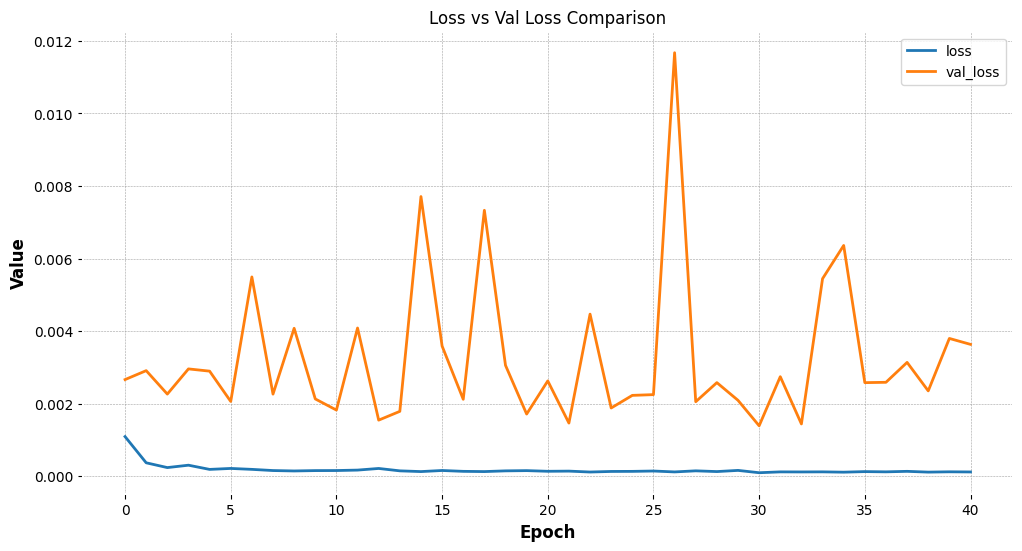

In [35]:
metric_plot(model_train_history, 'loss', 'val_loss', 'Loss vs Val Loss')

In [36]:
# Function to prepare dataset for prediction
def make_predict_dataset(start_date: str, end_date: str, tick: str, k: int):
  # Load raw data
  print("Started loading data")
  data = load_data(start_date, end_date, tick)
  print(f"Raw shape: {data.shape}")
  print("Raw head:", data.head())

  # Process and validate the data
  df = validate_data(start_date, end_date, tick)
  print(f"Processed shape: {df.shape}")
  print("Processed head:", df.head())

  # Define feature columns and target column
  feature_cols = ['Open', 'High', 'Low', 'Close_RSI', 'Close_EMA20', 'Close_EMA100', 'Close_EMA200']
  target_cols = 'TargetNextClose'

  # Scale the feature data
  scaled_data, scaled_data_train_scaler = scaling_data(df[feature_cols])
  print("Scaled data: ", scaled_data.shape)

  # Scale the target data
  scaled_target_next_close_train, scaled_target_next_close_scaler = scaling_data(df[target_cols].values.reshape(-1, 1))
  print("Scaled target next close: ", scaled_target_next_close_train.shape)

  # Create sequences for x_test and y_test
  x_test, y_test = [], []
  for i in range(num_look_back_days, len(scaled_data)):
    x_test.append(scaled_data[i - num_look_back_days:i])
    y_test.append(scaled_target_next_close_train[i])

  # Convert lists to numpy arrays
  x_test, y_test = np.array(x_test), np.array(y_test)
  print("Converted x_test: ", x_test.shape)
  print("Converted y_test: ", y_test.shape)

  # Ensure the index is in datetime format for both data and df
  if not isinstance(data.index, pd.DatetimeIndex):
    if "Date" in data.columns:
      data["Date"] = pd.to_datetime(data["Date"])
      data.set_index("Date", inplace=True)

  if not isinstance(df.index, pd.DatetimeIndex):
    if "Date" in df.columns:
      df["Date"] = pd.to_datetime(df["Date"])
      df.set_index("Date", inplace=True)

  # Return processed dataframe, scaled data, scaler for target, and test sequences
  return df, scaled_data, scaled_target_next_close_scaler, x_test, y_test

In [37]:
# Function to predict stock price for a single day using multivariate data
def multivariate_predict_for_single_day(model: any, tick: str, date: str):
  # Convert input date to datetime object
  pred_date = datetime.strptime(date, "%Y-%m-%d")
  # Set start date 3 years before prediction date
  start_date = pred_date - timedelta(365 * 3)
  # Print date range for prediction
  print(f"Date for multivariate predict: {start_date.strftime('%Y-%m-%d')} - {pred_date.strftime('%Y-%m-%d')}")

  # Prepare dataset for prediction
  df, scaled_date, scaler, x_test, y_test = make_predict_dataset(start_date.strftime('%Y-%m-%d'), pred_date.strftime('%Y-%m-%d'), tick)
  # Check if there's data available for prediction
  if len(x_test) == 0 or x_test[-1].shape[0] == 0:
    raise IndexError("No data is found for prediction")

  # Make prediction
  print("Predict")
  pred = model.predict(x_test[-1].reshape(1, -1, x_test.shape[-1]))
  print("Predicted")

  # Inverse transform the prediction to get actual price
  pred_price = scaler.inverse_transform(pred)

  # Print and return the predicted price
  print(f"Predicted Price for: {pred_date.strftime('%Y-%m-%d')} is: {pred_price[0][0]}")
  return pred_price


In [38]:
predict_date = '2023-09-22'
predicted_price = multivariate_predict_for_single_day(model, tick=ticker, date=predict_date)

Date for multivariate predict: 2020-09-22 - 2023-09-22
Started loading data


[*********************100%%**********************]  1 of 1 completed

Raw shape: (755, 6)
Raw head:                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-09-22  143.199997  145.919998  139.199997  141.410004  141.410004   
2020-09-23  135.053329  137.383331  125.293335  126.786667  126.786667   
2020-09-24  121.266670  133.166672  117.099998  129.263336  129.263336   
2020-09-25  131.156662  136.243332  130.433334  135.779999  135.779999   
2020-09-28  141.539993  142.693329  138.516663  140.399994  140.399994   

               Volume  
Date                   
2020-09-22  238742400  
2020-09-23  285222600  
2020-09-24  289683300  
2020-09-25  201625500  
2020-09-28  149158800  
Processing Raw Data...
Type of index after converted:  <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Processed shape: (555, 13)
Processed head:                   Open        High         Low       Close   Adj Close  \
Date                                                     

In [45]:
def multivariate_multistep_prediction(model: any, tick: str, start_date: str, end_date: str, k:int | None = 10):
  # Print the start and end dates for the prediction
  print(f"Start multivariate multistep prediction from: {start_date} to {end_date}")

  # Prepare the dataset for prediction
  df, scaled_data, scaler, x_test, y_test = make_predict_dataset(start_date, end_date, tick, k)

  # Extract the actual closing prices
  current_price = df['Close'].values

  # Make predictions for the past data
  past_predict_res = model.predict(x_test)
  # Inverse transform the predictions to get actual prices
  past_predict_res = scaler.inverse_transform(past_predict_res)
  past_predict_res = np.array(past_predict_res)

  # Initialize lists for future predictions
  future_predict_res = []
  future_input_data = x_test[-1]
  future_predict_dates = []

  # Convert the end date to datetime object
  last_predict_date = datetime.strptime(end_date, "%Y-%m-%d")

  # Generate future dates for prediction
  for i in range(1, k + 1):
    future_predict_dates.append(last_predict_date + timedelta(i))

  # Make predictions for future dates
  for i in range(k):
    # Predict the next price
    predicted_res = model.predict(future_input_data.reshape(1, -1, x_test.shape[-1]))
    # Inverse transform the prediction to get actual price
    predicted_price = scaler.inverse_transform(predicted_res)

    # Add the predicted price to the results
    future_predict_res.append(predicted_price)

    # Get the current prediction date
    curr_date = future_predict_dates[i]
    # Print the predicted price for the current date
    print(f"Predicted price for {curr_date.strftime('%Y-%m-%d')} is: {predicted_price}")

    # Update the input data for the next prediction
    future_input_data = np.roll(future_input_data, -1, axis=0)
    future_input_data[-1] = predicted_res

  # Convert future predictions to numpy array
  future_predict_res = np.array(future_predict_res)

  # Return the original dataframe, current prices, past predictions, and future predictions
  return df, current_price, past_predict_res, future_predict_res

In [47]:
end = datetime.now()
start = end - timedelta(days=365*3)
predict_df, current_price, past_predictions, future_predictions = multivariate_multistep_prediction(model, ticker, start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"), k=10)


Start multivariate multistep prediction from: 2021-09-24 to 2024-09-23
Started loading data
Raw shape: (752, 7)
Raw head:          Date        Open        High         Low       Close   Adj Close  \
0  2021-09-24  248.630005  258.266663  248.186661  258.130005  258.130005   
1  2021-09-27  257.706665  266.333344  256.436676  263.786682  263.786682   
2  2021-09-28  262.399994  265.213318  255.393326  259.186676  259.186676   
3  2021-09-29  259.933319  264.500000  256.893341  260.436676  260.436676   
4  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   

     Volume  
0  64119000  
1  84212100  
2  76144200  
3  62828700  
4  53868000  
Loading Prepared Data...
Processed shape: (552, 13)
Processed head:          Open        High         Low       Close   Adj Close    Volume  \
0  236.846664  239.773331  228.369995  233.070007  233.070007  87930900   
1  225.500000  242.059998  225.033340  237.039993  237.039993  97954500   
2  234.896667  238.653336  229.333328 